# (Alternative) Classification methods: 
###  Test different classification methods over a simple classification problem.

** Dataset: ** the UCI Abalone dataset, containing various features of abalones, including the age – to be inferred by 
the number or rings. 

Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the 
cone, staining it, and counting the number of rings through a microscope, a boring and time-consuming task. 
Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns
and location (hence food availability) may be required to solve the problem.

The Population Biology of Abalone (_Haliotis_species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait. 

** The ranges of the continuous values have been scaled for use with an ANN (by dividing by 200) **

** Parameters: **
- Sex: Nominal value representing the sex of the animal, can be either Male (M), Female (F), or Infant (I)
- Length: Continuous value (mm)	of the longest shell measurement
- Diameter:	Continuous value (mm) measured perpendicular to length
- Height: Continuous value (mm)	considering also the meat in shell
- Whole weight: Continuous value (grams) representing the weight of the whole abalone
- Shucked weight: Continuous value (grams) of the weight of just the mollusc meat
- Viscera weight: Continuous value (grams) of the gut weight after bleeding
- Shell weight: Continuous value (grams) of the animal after being dried
- Rings: Integer value that if added 1.5 gives the age in years

**Objectives:**  
(i) discard the “Infant” abalones;  
(ii) discretize the attribute “Number of rings” into 2 classes;  
(iii) try at least 3 different classification methods (among those discussed in DM2, including ensemble methods) on the resulting dataset, using the discretized n. of rings as class, and evaluating them with cross-validation.

** IMPORT LIBRARIES **

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm as cm

from sklearn import tree
from sklearn.tree import export_graphviz

from sklearn import metrics
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score

from scipy.stats import randint as sp_randint
from scipy.stats.mstats import gmean

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

** READ THE DATASET **

In [2]:
df_init = pd.read_csv("abalone.csv") 

In [3]:
print "The dataset has", df_init.shape[0], "rows and", df_init.shape[1], "columns."

The dataset has 4177 rows and 9 columns.


# ** OBJECTIVE 1: Discard the INFANT abalones **

In [4]:
df_init = df_init[df_init["Sex"] != "I"]
df_init.head(10)

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19
10,F,0.525,0.380,0.140,0.6065,0.1940,0.1475,0.210,14
11,M,0.430,0.350,0.110,0.4060,0.1675,0.0810,0.135,10


In [5]:
print "The dataset without Infant has", df_init.shape[0], "rows and", df_init.shape[1], "columns."

The dataset without Infant has 2835 rows and 9 columns.


## ** DATA CLEANING **

Discretize "Sex" attribute where F=0 and M=1

In [6]:
s = sorted(df_init['Sex'].unique())
genders_mapping = dict(zip(s, range(0, len(s) + 1)))
df_init['Sex'] = df_init['Sex'].map(genders_mapping).astype(int)

Rename all variables as they contain a space in the name, multiply all continuous values by 200 to obtain the real values and create the new attribute "Volume" to have a joint measure of the dimensions.

In [7]:
df_init["Length"] = df_init[" Length"]*200
del df_init[" Length"]

df_init["Diameter"] = df_init[" Diameter"]*200
del df_init[" Diameter"]

df_init["Height"] = df_init[" Height"]*200
del df_init[" Height"]

df_init["Volume"] = df_init["Length"]*df_init["Diameter"]*df_init["Height"]

df_init["WholeWeight"] = df_init[" WholeWeight"]*200
del df_init[" WholeWeight"]

df_init["ShuckedWeight"] = df_init[" ShuckedWeight"]*200
del df_init[" ShuckedWeight"]

df_init["VisceraWeight"] = df_init[" VisceraWeight"]*200
del df_init[" VisceraWeight"]

df_init["ShellWeight"] = df_init[" ShellWeight"]*200
del df_init[" ShellWeight"]

df_init["Rings"] = df_init[" Rings"]
del df_init[" Rings"]

In [8]:
df_init.head(10)

,Sex,Length,Diameter,Height,Volume,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,1,91.0,73.0,19.0,126217.0,102.8,44.9,20.2,30.0,15
1,1,70.0,53.0,18.0,66780.0,45.1,19.9,9.7,14.0,7
2,0,106.0,84.0,27.0,240408.0,135.4,51.3,28.3,42.0,9
3,1,88.0,73.0,25.0,160600.0,103.2,43.1,22.8,31.0,10
6,0,106.0,83.0,30.0,263940.0,155.5,47.4,28.3,66.0,20
7,0,109.0,85.0,25.0,231625.0,153.6,58.8,29.9,52.0,16
8,1,95.0,74.0,25.0,175750.0,101.9,43.3,22.5,33.0,9
9,0,110.0,88.0,30.0,290400.0,178.9,62.9,30.2,64.0,19
10,0,105.0,76.0,28.0,223440.0,121.3,38.8,29.5,42.0,14
11,1,86.0,70.0,22.0,132440.0,81.2,33.5,16.2,27.0,10


In [9]:
df_init.describe()

,Sex,Length,Diameter,Height,Volume,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,2835.000000,2835.000000,2835.000000,2835.000000,2.835000e+03,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,0.538977,113.910406,89.281481,30.887478,3.404315e+05,203.369841,87.810159,44.505256,58.241693,10.900882
std,0.498566,19.164143,15.770041,7.484284,1.585375e+05,90.643484,42.438661,20.376083,25.766987,3.069252
min,0.000000,31.000000,22.000000,3.000000,3.565000e+03,3.100000,1.300000,0.600000,1.000000,3.000000
25%,0.000000,103.000000,80.000000,27.000000,2.249760e+05,140.250000,57.400000,30.400000,40.500000,9.000000
50%,1.000000,117.000000,92.000000,31.000000,3.347470e+05,200.600000,86.300000,43.400000,57.000000,10.000000
75%,1.000000,127.000000,100.000000,35.000000,4.399560e+05,257.900000,113.750000,57.500000,73.000000,12.000000
max,1.000000,163.000000,130.000000,226.000000,1.641099e+06,565.100000,297.600000,152.000000,201.000000,29.000000


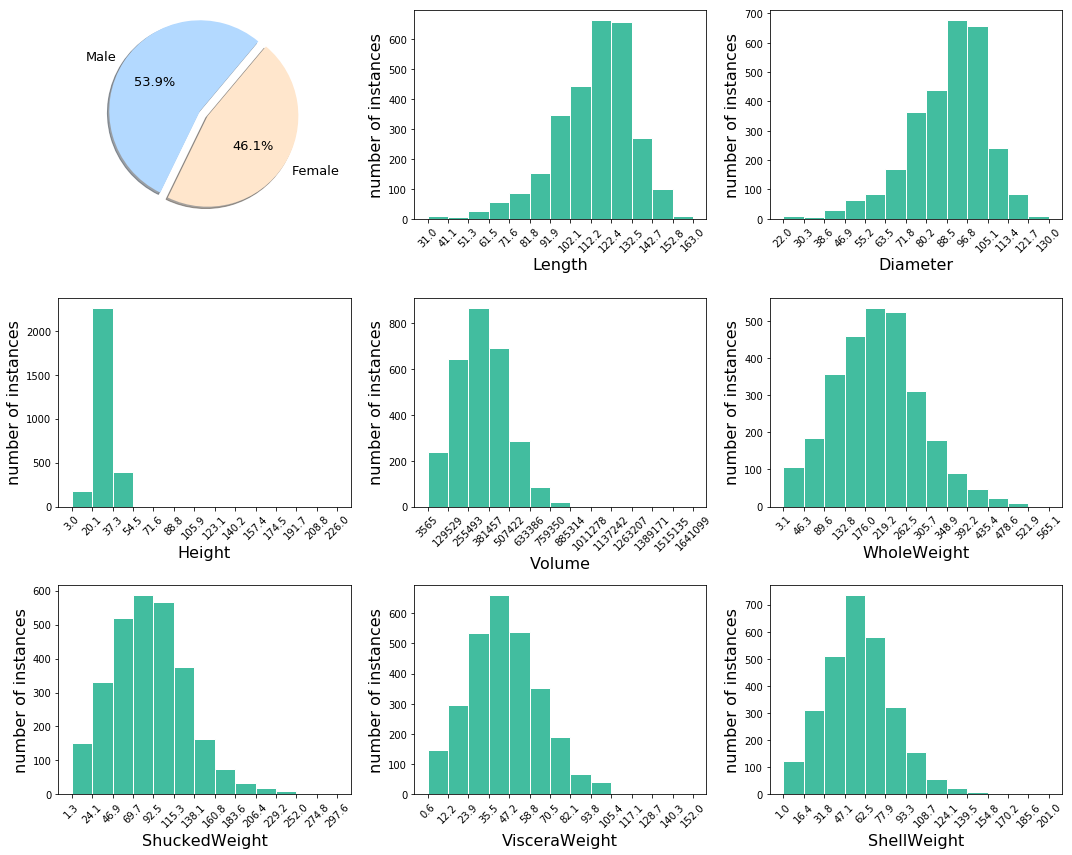

In [10]:
#single variables distribution
fig = plt.figure(figsize=(15, 12)) 
fig_dims = (3, 3)

#first row
#Sex -- pie
ax = plt.subplot2grid(fig_dims, (0, 0))
labels = 'Male', 'Female'
sizes = df_init['Sex'].value_counts()
explode = (0, 0.1)
inside, texts, ltexts = ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=50, colors=('#b3d9ff','#ffe6cc'))
for i in range(len(texts)):
    texts[i].set_fontsize(13)
    ltexts[i].set_fontsize(13)
ax.axis('equal') 
#Length -- histogram
ax = plt.subplot2grid(fig_dims, (0, 1))
_, bins, _ = plt.hist(df_init['Length'], 13, color = '#42BD9F', ec='#FFFFFF')
ax.set_xlabel("Length", fontsize=16)
ax.set_ylabel("number of instances", fontsize=16)
for i in range(len(bins)):
    bins[i] = round(bins[i], 2)
ax.set_xticks(bins)
plt.xticks(rotation = '45')
#Diameter -- histogram
ax = plt.subplot2grid(fig_dims, (0, 2))
_, bins, _ = plt.hist(df_init['Diameter'], 13, color = '#42BD9F', ec='#FFFFFF')
ax.set_xlabel("Diameter", fontsize=16)
ax.set_ylabel("number of instances", fontsize=16)
for i in range(len(bins)):
    bins[i] = round(bins[i], 2)
ax.set_xticks(bins)
plt.xticks(rotation = '45')

#second row
#Height -- histogram
ax = plt.subplot2grid(fig_dims, (1, 0))
_, bins, _ = plt.hist(df_init['Height'], 13, color = '#42BD9F', ec='#FFFFFF')
ax.set_xlabel("Height", fontsize=16)
ax.set_ylabel("number of instances", fontsize=16)
for i in range(len(bins)):
    bins[i] = round(bins[i], 2)
ax.set_xticks(bins)
plt.xticks(rotation = '45')
#Volume -- histogram
ax = plt.subplot2grid(fig_dims, (1, 1))
_, bins, _ = plt.hist(df_init['Volume'], 13, color = '#42BD9F', ec='#FFFFFF')
ax.set_xlabel("Volume", fontsize=16)
ax.set_ylabel("number of instances", fontsize=16)
for i in range(len(bins)):
    bins[i] = round(bins[i], 2)
ax.set_xticks(bins)
plt.xticks(rotation = '45')
#WholeWeight -- histogram
ax = plt.subplot2grid(fig_dims, (1, 2))
_, bins, _ = plt.hist(df_init['WholeWeight'], 13, color = '#42BD9F', ec='#FFFFFF')
ax.set_xlabel("WholeWeight", fontsize=16)
ax.set_ylabel("number of instances", fontsize=16)
for i in range(len(bins)):
    bins[i] = round(bins[i], 2)
ax.set_xticks(bins)
plt.xticks(rotation = '45')


#third row
#ShuckedWeight -- histogram
ax = plt.subplot2grid(fig_dims, (2, 0))
_, bins, _ = plt.hist(df_init['ShuckedWeight'], 13, color = '#42BD9F', ec='#FFFFFF')
ax.set_xlabel("ShuckedWeight", fontsize=16)
ax.set_ylabel("number of instances", fontsize=16)
for i in range(len(bins)):
    bins[i] = round(bins[i], 2)
ax.set_xticks(bins)
plt.xticks(rotation = '45')
#VisceraWeight -- histogram
ax = plt.subplot2grid(fig_dims, (2, 1))
_, bins, _ = plt.hist(df_init['VisceraWeight'], 13, color = '#42BD9F', ec='#FFFFFF')
ax.set_xlabel("VisceraWeight", fontsize=16)
ax.set_ylabel("number of instances", fontsize=16)
for i in range(len(bins)):
    bins[i] = round(bins[i], 2)
ax.set_xticks(bins)
plt.xticks(rotation = '45')
#ShellWeight -- histogram
ax = plt.subplot2grid(fig_dims, (2, 2))
_, bins, _ = plt.hist(df_init['ShellWeight'], 13, color = '#42BD9F', ec='#FFFFFF')
ax.set_xlabel("ShellWeight", fontsize=16)
ax.set_ylabel("number of instances", fontsize=16)
for i in range(len(bins)):
    bins[i] = round(bins[i], 2)
ax.set_xticks(bins)
plt.xticks(rotation = '45')

plt.tight_layout()
plt.show()

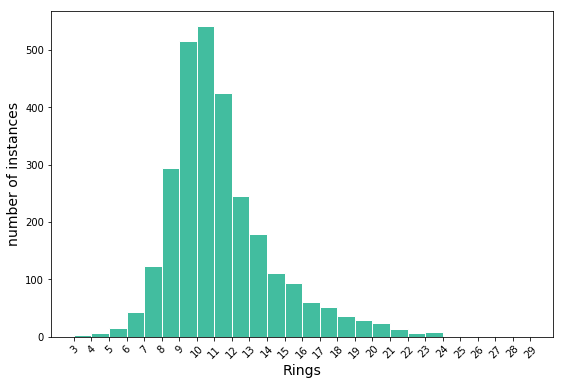

In [11]:
#Rings -- histogram
fig = plt.figure(figsize=(9, 6)) 
fig_dims = (1, 1)

ax = plt.subplot2grid(fig_dims, (0, 0))
_, bins, _ = plt.hist(df_init['Rings'], 26, color = '#42BD9F', ec='#FFFFFF')
ax.set_xlabel("Rings", fontsize=14)
ax.set_ylabel("number of instances", fontsize=14)
for i in range(len(bins)):
    bins[i] = round(bins[i], 2)
ax.set_xticks(bins)
plt.xticks(rotation = '45')

plt.savefig('Images/Classification/RingsHisto.png', format='png', bbox_inches='tight')
plt.show()

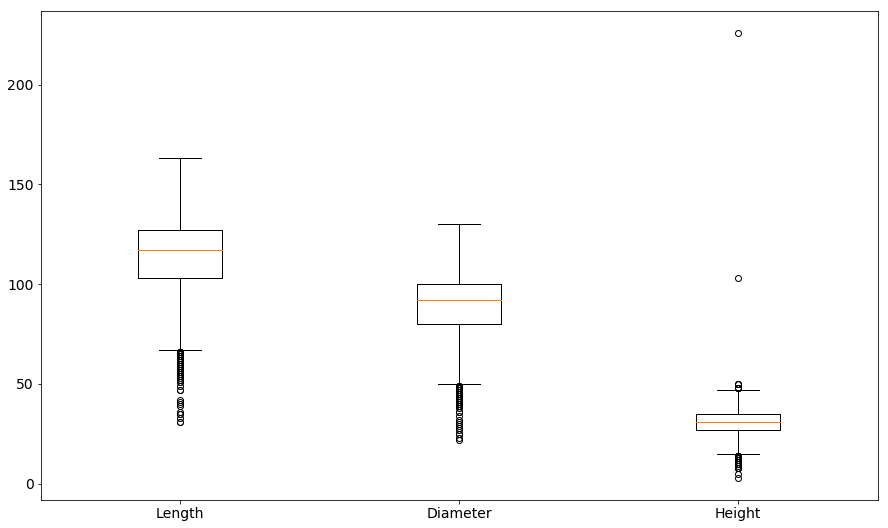

In [12]:
#boxplot
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
boxplot_data = [df_init["Length"], df_init["Diameter"], df_init["Height"]]
boxplot_labels = ['Length', 'Diameter','Height']
bp = ax.boxplot(boxplot_data, labels=boxplot_labels)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Remove the two explicit outliers of Height, since by normalizing they will be taken as max value, reducing the importance of the other values.

In [13]:
df_init = df_init[df_init.Height < 100]
print "The dataset without Infant has", df_init.shape[0], "rows and", df_init.shape[1], "columns."

The dataset without Infant has 2833 rows and 10 columns.


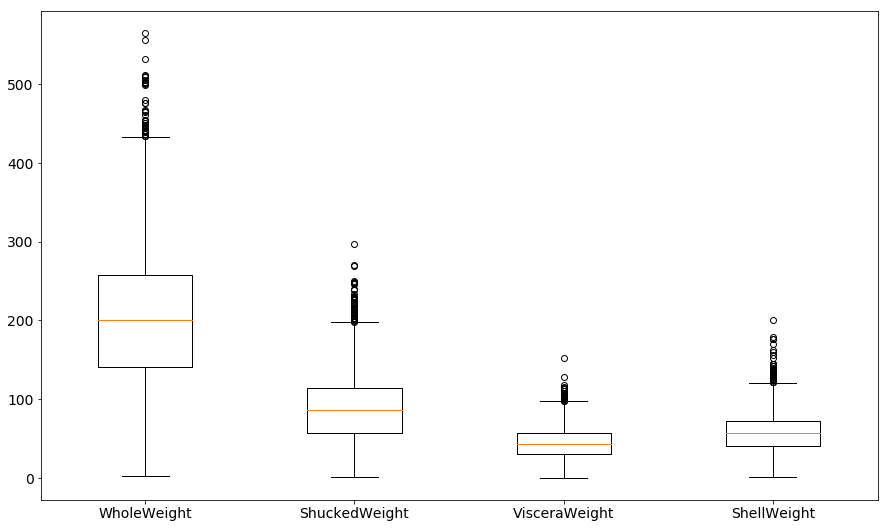

In [14]:
#boxplot
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
boxplot_data = [df_init["WholeWeight"], df_init["ShuckedWeight"], df_init["VisceraWeight"], df_init["ShellWeight"]]
boxplot_labels = ['WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight']
bp = ax.boxplot(boxplot_data, labels=boxplot_labels)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

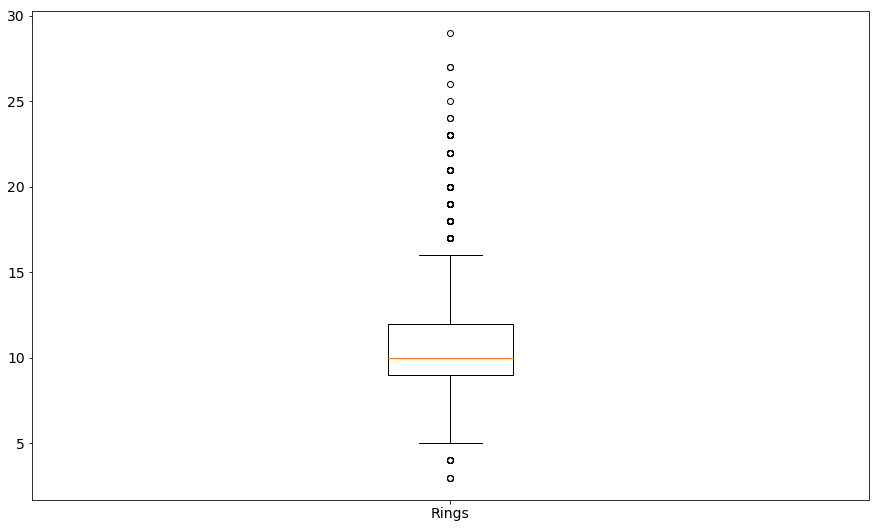

In [15]:
#boxplot
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
boxplot_data = [df_init["Rings"]]
boxplot_labels = ['Rings']
bp = ax.boxplot(boxplot_data, labels=boxplot_labels)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

# ** OBJECTIVE 2: Discretize the attribute “Number of rings” into 2 classes **

The class does not have a "visual" way to separate the rings in 2 parts

In [16]:
print "mean", df_init["Rings"].mean()
print "median", df_init["Rings"].median()

mean 10.902223791
median 10.0


We will divide the rings in 2 classes: Young (0) and Old (1), where a record belongs to Young if "Rings" <= 10

In [17]:
df = df_init.copy(deep=True)

c = sorted(df['Rings'].unique())
rings_mapping = dict(zip(c, range(0, len(c) + 1)))
df['Class'] = df['Rings'].apply(lambda x: 0 if x <= 10 else 1)
del df["Rings"]

In [18]:
print "Total values: ", df["Class"].count()
print "Young: ", df["Class"].value_counts()[0], "  perc:", (df["Class"].value_counts()[0] * 100 / df["Class"].count()), "%"
print "Old: ", df["Class"].value_counts()[1], "  perc:", (df["Class"].value_counts()[1] * 100 / df["Class"].count()), "%"

Total values:  2833
Young:  1541   perc: 54 %
Old:  1292   perc: 45 %


Before starting with the classification we normalize the values of the continuous attributes with the tecnique min-max. This way every value is in the range [0, 1] and classification methods based on the distance returns more accurate results.

In [19]:
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df=pd.DataFrame(x_scaled, columns=df.columns)

In [20]:
df.describe()

,Sex,Length,Diameter,Height,Volume,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Class
count,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000
mean,0.539005,0.628098,0.622959,0.591344,0.318213,0.356255,0.291834,0.289922,0.286186,0.456054
std,0.498564,0.145146,0.145977,0.135848,0.147052,0.161122,0.143022,0.134446,0.128780,0.498153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.545455,0.537037,0.510638,0.209660,0.244306,0.188998,0.196830,0.198000,0.000000
50%,1.000000,0.651515,0.648148,0.595745,0.313337,0.351423,0.286871,0.282695,0.280000,0.000000
75%,1.000000,0.727273,0.722222,0.680851,0.412899,0.453381,0.379345,0.375826,0.360000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
df.head(10)

,Sex,Length,Diameter,Height,Volume,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Class
0,1.0,0.454545,0.472222,0.340426,0.116155,0.177402,0.147148,0.129458,0.145,1.0
1,1.0,0.295455,0.287037,0.319149,0.059866,0.074733,0.062774,0.060106,0.065,0.0
2,0.0,0.568182,0.574074,0.510638,0.224297,0.235409,0.168748,0.182959,0.205,0.0
3,1.0,0.431818,0.472222,0.468085,0.148717,0.178114,0.141073,0.146631,0.150,0.0
4,0.0,0.568182,0.564815,0.574468,0.246582,0.271174,0.155586,0.182959,0.325,1.0
5,0.0,0.590909,0.583333,0.468085,0.215979,0.267794,0.194060,0.193527,0.255,1.0
6,1.0,0.484848,0.481481,0.468085,0.163064,0.175801,0.141748,0.144650,0.160,0.0
7,0.0,0.598485,0.611111,0.574468,0.271641,0.312811,0.207897,0.195509,0.315,1.0
8,0.0,0.560606,0.500000,0.531915,0.208228,0.210320,0.126561,0.190885,0.205,1.0
9,1.0,0.416667,0.444444,0.404255,0.122048,0.138968,0.108674,0.103038,0.130,0.0


Let's have a look at the distribution of the two classes created among the other attributes

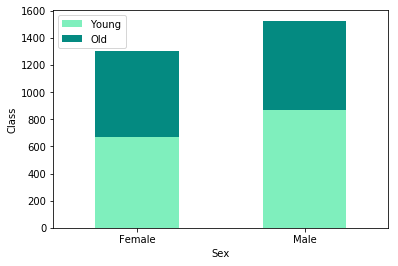

In [22]:
pclass_xt = pd.crosstab(df['Sex'], df['Class'])
pclass_xt.plot(kind='bar', stacked=True, color=['#7FEFBD', '#048A81'])
plt.xlabel('Sex')
plt.ylabel('Class')
plt.legend(('Young', 'Old'))
plt.xticks([0, 1], ('Female', 'Male'), rotation = '0')

plt.show()

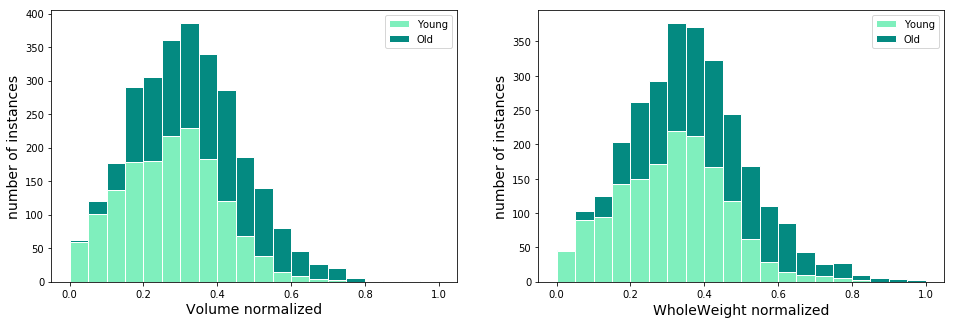

In [23]:
fig = plt.figure(figsize=(16, 5)) 
fig_dims = (1, 2)

ax = plt.subplot2grid(fig_dims, (0, 0))
n_bins = 20
x =[df[df["Class"] == 0]["Volume"], df[df["Class"] == 1]["Volume"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
plt.xlabel('Volume normalized', fontsize=14)
plt.ylabel('number of instances', fontsize=14)
plt.legend(('Young', 'Old'))

ax = plt.subplot2grid(fig_dims, (0, 1))
x =[df[df["Class"] == 0]["WholeWeight"], df[df["Class"] == 1]["WholeWeight"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
plt.xlabel('WholeWeight normalized', fontsize=14)
plt.ylabel('number of instances', fontsize=14)
plt.legend(('Young', 'Old'))

plt.savefig('Images/Classification/StackedPlot.png', format='png', bbox_inches='tight')
plt.show()

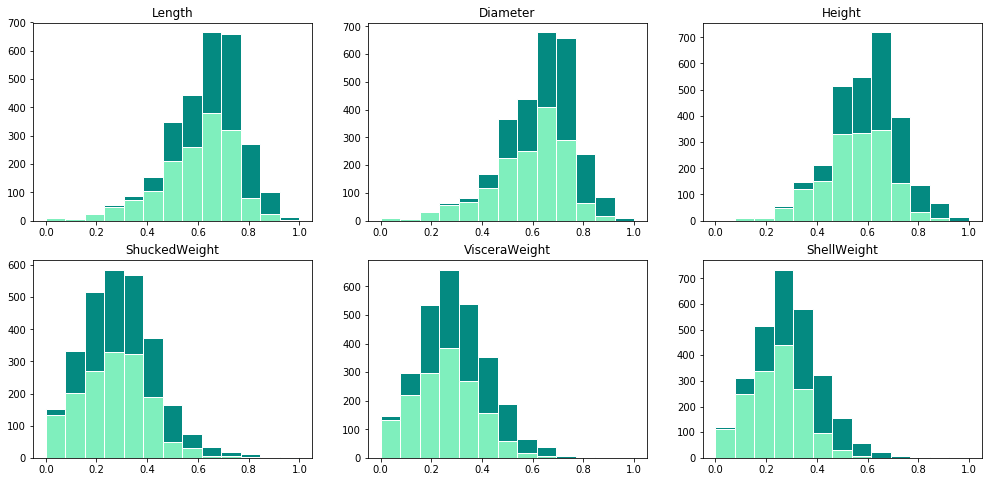

In [24]:
fig = plt.figure(figsize=(17, 8)) 
fig_dims = (2, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
n_bins = 13
x =[df[df["Class"] == 0]["Length"], df[df["Class"] == 1]["Length"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
ax.set_title('Length')

ax = plt.subplot2grid(fig_dims, (0, 1))
n_bins = 13
x =[df[df["Class"] == 0]["Diameter"], df[df["Class"] == 1]["Diameter"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
ax.set_title('Diameter')

ax = plt.subplot2grid(fig_dims, (0, 2))
n_bins = 13
x =[df[df["Class"] == 0]["Height"], df[df["Class"] == 1]["Height"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
ax.set_title('Height')

ax = plt.subplot2grid(fig_dims, (1, 0))
n_bins = 13
x =[df[df["Class"] == 0]["ShuckedWeight"], df[df["Class"] == 1]["ShuckedWeight"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
ax.set_title('ShuckedWeight')

ax = plt.subplot2grid(fig_dims, (1, 1))
n_bins = 13
x =[df[df["Class"] == 0]["VisceraWeight"], df[df["Class"] == 1]["VisceraWeight"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
ax.set_title('VisceraWeight')

ax = plt.subplot2grid(fig_dims, (1, 2))
n_bins = 13
x =[df[df["Class"] == 0]["ShellWeight"], df[df["Class"] == 1]["ShellWeight"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
ax.set_title('ShellWeight')

plt.show()

As predictable, the older animals are mainly spread among the bigger and heavier Abalone.

Let's compute the correlation matrix in order to see in there's good correlation between attributes.

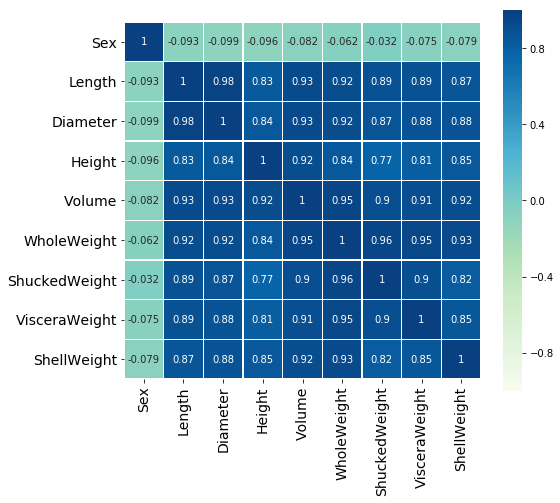

In [25]:
cmap = cm.get_cmap('GnBu')

fig = plt.figure()
fig.set_size_inches(8,7)

correlati = df.loc[:, :'ShellWeight'].corr()
ax = sns.heatmap(correlati, square=True, cmap=cmap, vmin = -1, vmax = 1, annot = True,linewidths=.5)
plt.xticks(rotation=90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
labels = ['Sex', 'Length', 'Diameter', 'Height', 'Volume', 'WholeWeight', 'ShuckedWeight', "VisceraWeight", "ShellWeight"]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.show()

# ** OBJECTIVE 3:  Try at least 3 classification methods on the resulting dataset **

Use the discretized n. of rings as class, and evaluate them with cross-validation.
Use 3 methods among those discussed in DM2, including ensemble methods.

The two classes are well balanced, there's no need to undersample/oversample

Convert the DataFrame to a numpy array

In [26]:
train_data = df.values
train_data

array([[ 1.        ,  0.45454545,  0.47222222, ...,  0.12945839,
         0.145     ,  1.        ],
       [ 1.        ,  0.29545455,  0.28703704, ...,  0.06010568,
         0.065     ,  0.        ],
       [ 0.        ,  0.56818182,  0.57407407, ...,  0.18295905,
         0.205     ,  0.        ],
       ..., 
       [ 1.        ,  0.67424242,  0.67592593, ...,  0.37582563,
         0.303     ,  0.        ],
       [ 0.        ,  0.71212121,  0.69444444, ...,  0.34081902,
         0.291     ,  0.        ],
       [ 1.        ,  0.84090909,  0.82407407, ...,  0.49339498,
         0.49      ,  1.        ]])

Divide the dataset from the "Class" column

In [27]:
# Dataset features without the column "Class"
train_features = train_data[:, :-1]

# 'Class' column values
train_target = train_data[:, -1]

Split arrays or matrices into random train and test subsets. Where the test set is 30% of the whole dataset.

In [28]:
train_x, test_x, train_y, test_y = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.3, 
                                                    random_state=1)

In [29]:
print "total number of records: ", len(train_data)
print "size of training set: ", len(train_x), "where", pd.value_counts(train_y)[0], "Young and", pd.value_counts(train_y)[1], "Old"
print "size of test set: ", len(test_x), "where", pd.value_counts(test_y)[0], "Young and", pd.value_counts(test_y)[1], "Old"

total number of records:  2833
size of training set:  1983 where 1086 Young and 897 Old
size of test set:  850 where 455 Young and 395 Old


## BASIC CLASSIFICATION

### RANDOM FOREST

First try is to execute the random forest classifier with a standard set of parameters

In [30]:
clf = RandomForestClassifier(n_estimators=10, 
                             criterion='gini',
                             max_features="auto",
                             max_depth=None, 
                             min_samples_split=2,
                             min_samples_leaf=1,
                             bootstrap=True,
                             oob_score=False,
                             random_state=1,
                             class_weight=None) #balanced

clf.fit(train_x, train_y)

print 'Accuracy Training:', round(cross_val_score(clf, train_x, train_y, cv=10).mean(), 4)
test_pred = clf.predict(test_x)
print 'Accuracy Test:', round(metrics.precision_score(test_y, test_pred, average='weighted'), 4)

Accuracy Training: 0.7025
Accuracy Test: 0.6997


The results are not much better then the decision tree above. We have to decide a set of parameters suitable for our dataset.

RandomizedSearchCV implements a "fit" and a "score" method in order to estimate the best set of parameters to use.

In [31]:
clf = RandomForestClassifier(n_estimators=20)

param_dist = {"max_depth": [2,3,4,5,6,7,8,9,10,11,12,None],
              "max_features": sp_randint(1, len(train_x[0]) + 1),
              "min_samples_split": sp_randint(5, 70),
              "min_samples_leaf": sp_randint(5, 70),
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0: 0.7, 1: 0.3}]}

n_iter_search = 200
search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, 
                            n_jobs=10, scoring=make_scorer(accuracy_score), random_state=1)

search.fit(train_x, train_y)

C:\Users\Francesca\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=10,
          param_distributions={'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000010136278>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000012A4F048>, 'criterion': ['entropy', 'gini'], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000E78F518>, 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None], 'class_weight': ['balan

Each time we might get slightly different result that varies on the set taken on the cross validation

In [32]:
search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=44, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We perform an experiment using the best set of attributes

In [33]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=38, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=1, verbose=0,
            warm_start=False) 

rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=38, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [34]:
feat_imp = rf.feature_importances_
for i in range(len(feat_imp)):
    feat_imp[i] = round(feat_imp[i], 3)
    
print "Sex", feat_imp[0], "   Length", feat_imp[1], "   Diameter", feat_imp[2], "   Height", feat_imp[3], "     Volume", feat_imp[4]     
print "WholeWeight", feat_imp[5], "   ShuckedWeight", feat_imp[6], "   VisceraWeight", feat_imp[7], "   ShellWeight", feat_imp[8]   

Sex 0.005    Length 0.02    Diameter 0.009    Height 0.021      Volume 0.046
WholeWeight 0.05    ShuckedWeight 0.29    VisceraWeight 0.02    ShellWeight 0.537


As predictable to understand if an abalone is young or old the sex is the least important feature.
The dimensions are not very important either. The weight is the most important feature, as the animal gets heavier
as it grows older. ShellWeight is the most important feature to understand whether the abalone is young or old, the ShuckedWeigth is useful to understand if it's a big animal but still young. Other measures are used to identify some odd animals.

In [35]:
print 'Accuracy Training:', round(cross_val_score(rf, train_x, train_y, cv=10).mean(), 4)
test_pred = rf.predict(test_x)
print 'Accuracy Test:', round(metrics.precision_score(test_y, test_pred, average='weighted'), 4)

Accuracy Training: 0.7312
Accuracy Test: 0.7042


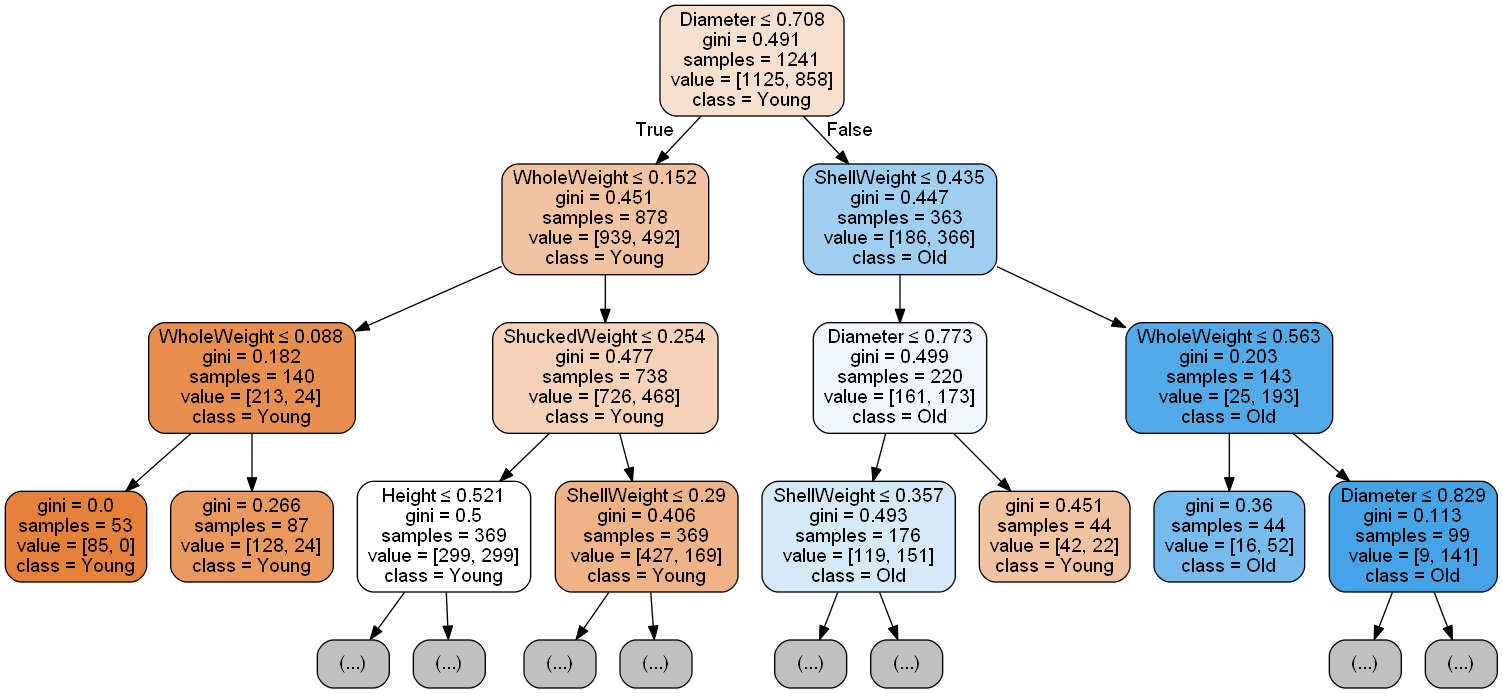

In [36]:
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(search.best_estimator_.estimators_[0], out_file=None, 
                         feature_names=list(df.columns[0:-1]),  
                         class_names=['Young', 'Old'],  
                         filled=True, rounded=True,  
                         special_characters=True,
                               max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

## ADVANCED CLASSIFICATION

### K-NN

We will use the sklearn library KNeighborsClassifier to classify the records.

The parameters that have to be chosen are:
- n_neighbors: default is 5
- weights: 'uniform' or 'distance', it states how to compute the value of each neighbour

We try every option with the number of neighbours from 10 to 100 and both values for weights. We perform a cross validation analysis to find the best set of parameters. 

In [37]:
nns = list(range(10, 100))
cv_scores_uniform = []
cv_scores_distance = []

for k in nns:
    knn_u = neighbors.KNeighborsClassifier(n_neighbors=k, weights="uniform")
    knn_d = neighbors.KNeighborsClassifier(n_neighbors=k, weights="distance")
    scores_u = cross_val_score(knn_u, train_x, train_y, cv=10, scoring='accuracy')
    scores_d = cross_val_score(knn_d, train_x, train_y, cv=10, scoring='accuracy')
    cv_scores_uniform.append(scores_u.mean())
    cv_scores_distance.append(scores_d.mean())

The cross validation procedure takes the training set and divides it in k parts (usually 10). k-1 parts are used as training and 1 is used for validation. The procedure is reapated k times, using each time a different set for validation.

The best results obtained for both combinations are:

In [38]:
index_uni = cv_scores_uniform.index(max(cv_scores_uniform))+10
index_dist = cv_scores_distance.index(max(cv_scores_distance))+10
max_accur_uni = max(cv_scores_uniform)
max_accur_dist = max(cv_scores_distance)

print "weights: uniform,   k:", index_uni, ",   accuracy:", max_accur_uni
print "weights: distance,   k:", index_dist, ",   accuracy:", max_accur_dist

weights: uniform,   k: 15 ,   accuracy: 0.722108710501
weights: distance,   k: 54 ,   accuracy: 0.72364432015


We can also plot the trend of the accuracy to understand the distribution. The light blue line is the uniform while distance is the darker one. Using the distance seems to return slightly better results.

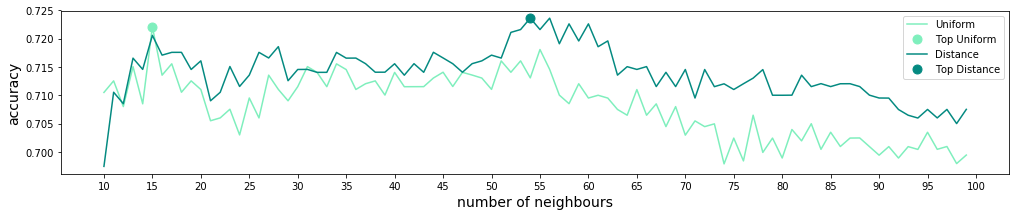

In [39]:
fig = plt.figure(figsize=[17, 3])
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot(range(10,100), cv_scores_uniform, color='#7FEFBD')
plt.plot(index_uni, max_accur_uni, 'o', color='#7FEFBD', markersize=9)
ax.plot(range(10,100), cv_scores_distance, color='#048A81')
plt.plot(index_dist, max_accur_dist, 'o', color='#048A81', markersize=9)
plt.xticks(np.arange(10, 101, step=5))
plt.xlabel('number of neighbours', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(('Uniform', 'Top Uniform', 'Distance', 'Top Distance'))

plt.savefig('Images/Classification/KNNscores.png', format='png', bbox_inches='tight')
plt.show()

Now we use the best classifier to fit the tranining and predict the results for both training and test set.

In [40]:
knn = neighbors.KNeighborsClassifier(index_dist, weights='distance')

In [41]:
knn.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=54, p=2,
           weights='distance')

First let's try cross validation on the training set.

In [42]:
print 'Accuracy Training:', round(cross_val_score(knn, train_x, train_y, cv=10).mean(), 4)
test_pred = knn.predict(test_x)
print 'Accuracy Test:', round(metrics.precision_score(test_y, test_pred, average='weighted'), 4)

Accuracy Training: 0.7236
Accuracy Test: 0.6982


Then on the test set we can predict the outcome of the class, measure the percentage of error and the compare the confusion matrix.

In [43]:
for i in range(5):
    p = knn.predict(test_x[i].reshape(1, -1))
    print i, ":", test_x[i], "predicted: ", p[0], " real: ", test_y[i]

0 : [ 1.          0.93939394  0.85185185  0.87234043  0.73291917  0.71761566
  0.49173135  0.62417437  0.6535    ] predicted:  1.0  real:  1.0
1 : [ 1.          0.70454545  0.69444444  0.80851064  0.4636488   0.42829181
  0.25717179  0.32694848  0.38      ] predicted:  1.0  real:  1.0
2 : [ 0.          0.70454545  0.67592593  0.61702128  0.35361552  0.39644128
  0.30813365  0.35072655  0.325     ] predicted:  0.0  real:  0.0
3 : [ 0.          0.81818182  0.83333333  0.72340426  0.54212712  0.62491103
  0.54876814  0.4332893   0.432     ] predicted:  1.0  real:  0.0
4 : [ 1.          0.43181818  0.44444444  0.53191489  0.15996723  0.15498221
  0.11103611  0.08916777  0.179     ] predicted:  0.0  real:  1.0


In [44]:
print "error: ", sum(abs(np.array(knn.predict(test_x)) - np.array(test_y)))
print "size test set: ", len(test_x)
print "correct answers: ", (len(test_x) - sum(abs(np.array(knn.predict(test_x)) - np.array(test_y)))) / len(test_x)

error:  262.0
size test set:  850
correct answers:  0.691764705882


In [45]:
test_pred = knn.predict(test_x)
cm = confusion_matrix(test_y, test_pred)
print "TN:", cm[0][0], "  FP:", cm[0][1]
print "FN:", cm[1][0], "  TP:", cm[1][1]

TN: 375   FP: 80
FN: 182   TP: 213


The TN, the highest value, is when it's correctly classified a Young (0) Abalone. The older ones are less defined, so the error is higher.

The results obtained from k-nn are slighly worse than the ones obtained with the random forest.

### NAIVE BAYES

We will use the sklearn library naive_bayes to classify the records. In particular the distribution of all the attributes is close to the gaussian so in order to classify we will use the GaussianNB module.

This method requires just one parameter that assigns priority to the classes. Since we're not interested in one in particular we will ignore this parameter. 

In [46]:
gnb = GaussianNB()

In [47]:
gnb.fit(train_x, train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

Once fitted the training set we can use cross validation in order to see the performance. In this case the accuracy is even worse than the simpler methods used above.

In [48]:
print 'Accuracy Training:', round(cross_val_score(gnb, train_x, train_y, cv=10).mean(), 4)
test_pred = gnb.predict(test_x)
print 'Accuracy Test:', round(metrics.precision_score(test_y, test_pred, average='weighted'), 4)

Accuracy Training: 0.6198
Accuracy Test: 0.6158


As for k-nn we can check the performance 

In [49]:
for i in range(5):
    p = gnb.predict(test_x[i].reshape(1, -1))
    print i, ":", test_x[i], "predicted: ", p[0], " real: ", test_y[i]

0 : [ 1.          0.93939394  0.85185185  0.87234043  0.73291917  0.71761566
  0.49173135  0.62417437  0.6535    ] predicted:  1.0  real:  1.0
1 : [ 1.          0.70454545  0.69444444  0.80851064  0.4636488   0.42829181
  0.25717179  0.32694848  0.38      ] predicted:  1.0  real:  1.0
2 : [ 0.          0.70454545  0.67592593  0.61702128  0.35361552  0.39644128
  0.30813365  0.35072655  0.325     ] predicted:  1.0  real:  0.0
3 : [ 0.          0.81818182  0.83333333  0.72340426  0.54212712  0.62491103
  0.54876814  0.4332893   0.432     ] predicted:  1.0  real:  0.0
4 : [ 1.          0.43181818  0.44444444  0.53191489  0.15996723  0.15498221
  0.11103611  0.08916777  0.179     ] predicted:  0.0  real:  1.0


In [50]:
print "error: ", sum(abs(np.array(gnb.predict(test_x)) - np.array(test_y)))
print "size test set: ", len(test_x)
print "correct answers: ", (len(test_x) - sum(abs(np.array(gnb.predict(test_x)) - np.array(test_y)))) / len(test_x)

error:  327.0
size test set:  850
correct answers:  0.615294117647


In this case the performance is even worse. 0.61 on the accuracy on the training set is really too low.

### ANN

The sklearn method MLPClassifier for neural networks takes a lot of parameters that needs to be tuned:

- hidden_layer_sizes : The ith element represents the number of neurons in the ith hidden layer, default (100,) 
- activation : Activation function for the hidden layer, {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default ‘relu’
- solver : The solver for weight optimization, {‘lbfgs’, ‘sgd’, ‘adam’}, default ‘adam’
- alpha : L2 penalty, default 0.0001
- learning_rate : Learning rate schedule for weight updates, {‘constant’, ‘invscaling’, ‘adaptive’}, default ‘constant’

We will use a RandomizedSearchCV to find the most appropriate ones (GridSearchCV is too slow).

In [51]:
mlp = MLPClassifier(max_iter=100)

There is no correct way to set the number of hidden layers and the number of neurons in each. 

Regarding the number of hidden layers, there is currently no theoretical reason to use neural networks with any more than two hidden layers. Moreover, problems that require two hidden layers are rarely encountered and they're very difficult to train. 
So the hidden layer configuration can be done by setting the number of hidden layers equals one. It was tested however with two and no improvement was found.

The number of neurons in the layer determins the degree of freedom in the classification. Taking too many neurons implies overfitting, while too few underfitting.

A way to choose the number of neurons is to take the mean of the neurons in the input and output. Where the input layer is made of a number of neurons equal to the number of features in the data (9) and the output layer is made of a single node (the predicted class). So this would advice to take 5 neurons.

Another way found in the litterature is to take as upper bound on the number of hidden neurons: Nh = Ns / (α∗(Ni+No)) where:
- Ni is the number of input neurons. (9)
- No = number of output neurons. (1)
- Ns = number of samples in training data set. (1983)
- α = an arbitrary scaling factor usually 5-10.

So take a number below 40 neurons to avoid overfitting.

In [52]:
parameter_space = {
    'hidden_layer_sizes': [(5,), (10,), (15,), (20,), (25,), (30,), (35,), (40,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
}

In [53]:
ann = RandomizedSearchCV(mlp, param_distributions=parameter_space, n_iter=200, 
                            n_jobs=10, scoring=make_scorer(accuracy_score), random_state=1)

In [54]:
ann.fit(train_x, train_y)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=10,
          param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate': ['constant', 'adaptive', 'invscaling'], 'hidden_layer_sizes': [(5,), (10,), (15,), (20,), (25,), (30,), (35,), (40,)]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn',

Once the data is fitted on the whole dataset we can print the best set of parameters found

In [55]:
ann.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (35,),
 'learning_rate': 'constant',
 'solver': 'lbfgs'}

And use these parameters to compute the classification on the training set.

In [56]:
ann = MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(30,), learning_rate='constant', solver='lbfgs')

In [57]:
ann.fit(train_x, train_y)                         

MLPClassifier(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In order to check the performance we use a cross validation tecnique.

In [58]:
print 'Accuracy Training:', round(cross_val_score(ann, train_x, train_y, cv=10).mean(), 4)
test_pred = ann.predict(test_x)
print 'Accuracy Test:', round(metrics.precision_score(test_y, test_pred, average='weighted'), 4)

Accuracy Training: 0.7469
Accuracy Test: 0.7302


The results are definitely better than the ones from the previous methods. The two accuracy values are quite close together so there is no underfitting or overfitting.

As for the methods above let's print the error rate of the classification on the test set.

In [59]:
print "error: ", sum(abs(np.array(ann.predict(test_x)) - np.array(test_y)))
print "size test set: ", len(test_x)
print "correct answers: ", (len(test_x) - sum(abs(np.array(ann.predict(test_x)) - np.array(test_y)))) / len(test_x)

error:  230.0
size test set:  850
correct answers:  0.729411764706


The results are definetely the best obtained so far.

### SVM

We will use the sklearn SVC library. The only parameter that we're interested in setting is the penalty parameter of the error term. 

Since it's a short computation we will do an exhaustive search of the best value. In order to avoid overfitting we will compute the results of the cross validation both on the training and on the test set.

In [60]:
c_par = range(1, 16)
cv_scores_train = []
cv_scores_test = []

for c in c_par:
    s = svm.SVC(c)
    s.fit(train_x, train_y)
    scores_tr = round(cross_val_score(s, train_x, train_y, cv=10).mean(), 4)
    test_pred = s.predict(test_x)
    scores_te = round(metrics.precision_score(test_y, test_pred, average='weighted'), 4)
    cv_scores_train.append(scores_tr)
    cv_scores_test.append(scores_te)

C:\Users\Francesca\Anaconda2\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


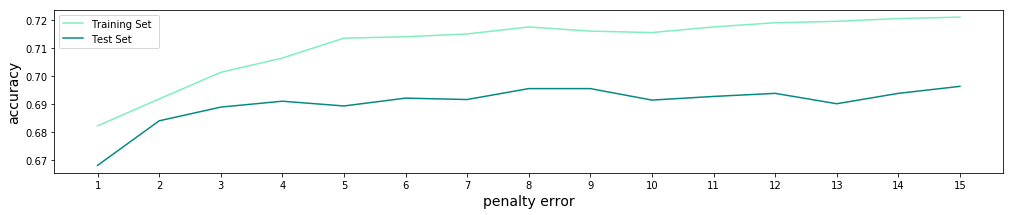

In [61]:
fig = plt.figure(figsize=[17, 3])
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot(c_par, cv_scores_train, color='#7FEFBD')
ax.plot(c_par, cv_scores_test, color='#048A81')
plt.xticks(c_par)
plt.xlabel('penalty error', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(('Training Set ', 'Test Set'))

plt.savefig('Images/Classification/SVMscores.png', format='png', bbox_inches='tight')
plt.show()

8 is the best value since from that point forward the accuracy of the test set starts to decrease.

Now we perform our classification with this parameter.

In [62]:
s = svm.SVC(8, probability=True)

In [63]:
s.fit(train_x, train_y)

SVC(C=8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [64]:
print 'Accuracy Training:', round(cross_val_score(s, train_x, train_y, cv=10).mean(), 4)
test_pred = s.predict(test_x)
print 'Accuracy Test:', round(metrics.precision_score(test_y, test_pred, average='weighted'), 4)

Accuracy Training: 0.7176
Accuracy Test: 0.6956


In [65]:
print "error: ", sum(abs(np.array(s.predict(test_x)) - np.array(test_y)))
print "size test set: ", len(test_x)
print "correct answers: ", (len(test_x) - sum(abs(np.array(s.predict(test_x)) - np.array(test_y)))) / len(test_x)

error:  266.0
size test set:  850
correct answers:  0.687058823529


The performance is not the best but it's ok.

## ENSAMBLE METHODS

### BAGGING

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. 

So we create a type of weak classifier and we give it to the bagging classifier. 

In [66]:
clf = tree.DecisionTreeClassifier()

In [67]:
bg = BaggingClassifier(clf, n_estimators=50, random_state=1)

The parameters to be set for bagging are:
- base_estimator : The base estimator to fit on random subsets of the dataset. If None, then the base estimator is a decision tree (default=None)
- n_estimators : The number of base estimators in the ensemble (default=10)
- max_samples : Percentage (from 0 to 1) of dataset to train each base estimator on (default=1.0)
- max_features : Number of features to use for each estimator
- bootstrap : Whether samples are drawn with replacement (default=True)

Moreover we can choose the parameters for the weak classifier such as max_depth, min_sample_split, min_samples_leaf or criterion.

In [68]:
parameter_space = {
    'base_estimator__max_depth' : [2,3,5,7,10,None],
    'base_estimator__min_samples_split' : [2,5,10,30,50,80],
    'base_estimator__min_samples_leaf' : [2,5,10,30,50,80],
    'base_estimator__criterion' : ["entropy", "gini"],
    
    'max_samples' : [0.1, 0.5, 1.0],
    'max_features' : [5, 6, 7, 8, 9],
    'bootstrap' : [True, False]
}

We use the RandomizedSearchCV as the GridSearch would be too long to execute.

In [69]:
b = RandomizedSearchCV(bg, param_distributions=parameter_space, n_iter=100, 
                            n_jobs=10, scoring=make_scorer(accuracy_score), random_state= 1)

In [70]:
b.fit(train_x, train_y)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ...n_estimators=50, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=10,
          param_distributions={'max_samples': [0.1, 0.5, 1.0], 'base_estimator__min_samples_split': [2, 5, 10, 30, 50, 80], 'base_estimator__max_depth': [2, 3, 5, 7, 10, None], 'bootstrap': [True, False], 'base_estimator__criterion': ['entropy', 'gini'], 'max_features': [5, 6, 7, 8, 9], 'base_estimator__min_samples_leaf': [2, 5, 10, 30, 50, 80]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=mak

Once fitted, we take a look at the best set of parameters and we use them to classify our data.

In [71]:
b.best_params_

{'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 7,
 'base_estimator__min_samples_leaf': 2,
 'base_estimator__min_samples_split': 30,
 'bootstrap': False,
 'max_features': 7,
 'max_samples': 0.5}

In [72]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=30, min_samples_leaf=2)
b = BaggingClassifier(clf, n_estimators=200, max_features= 7, max_samples=0.5, bootstrap=False)

In [73]:
b.fit(train_x, train_y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=30,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=False, bootstrap_features=False, max_features=7,
         max_samples=0.5, n_estimators=200, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

As we did for the previous methods we check the accuracy score through cross validation for both the training and test set.

In [74]:
print 'Accuracy Training:', round(cross_val_score(b, train_x, train_y, cv=10).mean(), 4)
test_pred = b.predict(test_x)
print 'Accuracy Test:', round(metrics.precision_score(test_y, test_pred, average='weighted'), 4)

Accuracy Training: 0.7302
Accuracy Test: 0.7137


The results obtained are quite good, they're second only to ANN.

### BOOSTING

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

The procedure is the same we followed for bagging, we choose a weak classifier and we give it to the AdaBoost in order to improve it's performances.

In [75]:
clf = tree.DecisionTreeClassifier()

In [76]:
ada = AdaBoostClassifier(base_estimator=clf, n_estimators=50, random_state = 1)

In [77]:
parameter_space = {
    'base_estimator__max_depth' : [2,3,5,7,10,None],
    'base_estimator__min_samples_split' : [2,5,10,30,50,80],
    'base_estimator__min_samples_leaf' : [2,5,10,30,50,80],
    'base_estimator__criterion' : ["entropy", "gini"],
    
    'algorithm' : ['SAMME', 'SAMME.R'],
    'learning_rate' : [0.1, 0.5, 1]
}

In [78]:
a = RandomizedSearchCV(ada, param_distributions=parameter_space, n_iter=200, 
                            n_jobs=10, scoring=make_scorer(accuracy_score), random_state = 1)

In [79]:
a.fit(train_x, train_y)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=1),
          fit_params=None, iid='warn', n_iter=200, n_jobs=10,
          param_distributions={'base_estimator__min_samples_split': [2, 5, 10, 30, 50, 80], 'base_estimator__max_depth': [2, 3, 5, 7, 10, None], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.1, 0.5, 1], 'base_estimator__criterion': ['entropy', 'gini'], 'base_estimator__min_samples_leaf': [2, 5, 10, 30, 50, 80]},
          pre_dispatch='2*n_jobs', random_state=1, re

In [80]:
a.best_params_

{'algorithm': 'SAMME.R',
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 3,
 'base_estimator__min_samples_leaf': 80,
 'base_estimator__min_samples_split': 2,
 'learning_rate': 0.1}

And we use the results obtained to build the best classifier.

In [81]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2, min_samples_leaf=80)
ada = AdaBoostClassifier(base_estimator=clf, n_estimators=200, algorithm = 'SAMME.R', learning_rate = 0.1 )

In [82]:
ada.fit(train_x, train_y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=80, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=200, random_state=None)

In [83]:
print 'Accuracy Training:', round(cross_val_score(ada, train_x, train_y, cv=10).mean(), 4)
test_pred = ada.predict(test_x)
print 'Accuracy Test:', round(metrics.precision_score(test_y, test_pred, average='weighted'), 4)

Accuracy Training: 0.7262
Accuracy Test: 0.7081


The results are not so much better than the Decision Tree alone. The accuracy score is close to the one of KNN and SVM.

# CONCLUSIONS

The ACCURACY scores obtained on the TRAINING set for the classification methods, in an increasing order, are:
- ANN: 0.7464 (ann)
- Bagging: 0.7327 (b)
- Random Forest: 0.7312 (rf)
- Boosting 0.7262 (a)
- K-NN: 0.7236 (knn)
- SVM: 0.7176 (s)
- Naive Bayes: 0.6198 (gnb)

The ACCURACY scores obtained on the TEST set for the classification methods, in an increasing order, are:
- ANN: 0.7233 (ann)
- Bagging: 0.7128 (b)
- Boosting 0.7081 (a)
- Random Forest: 0.7042 (rf)
- K-NN: 0.6982 (knn)
- SVM: 0.6956 (s)
- Naive Bayes: 0.6158 (gnb)

(Boosting outmatched Random Forest for testing)

Let's do a double check on the performance of these classifiers by drawing the ROC curve and computing the AUC score.

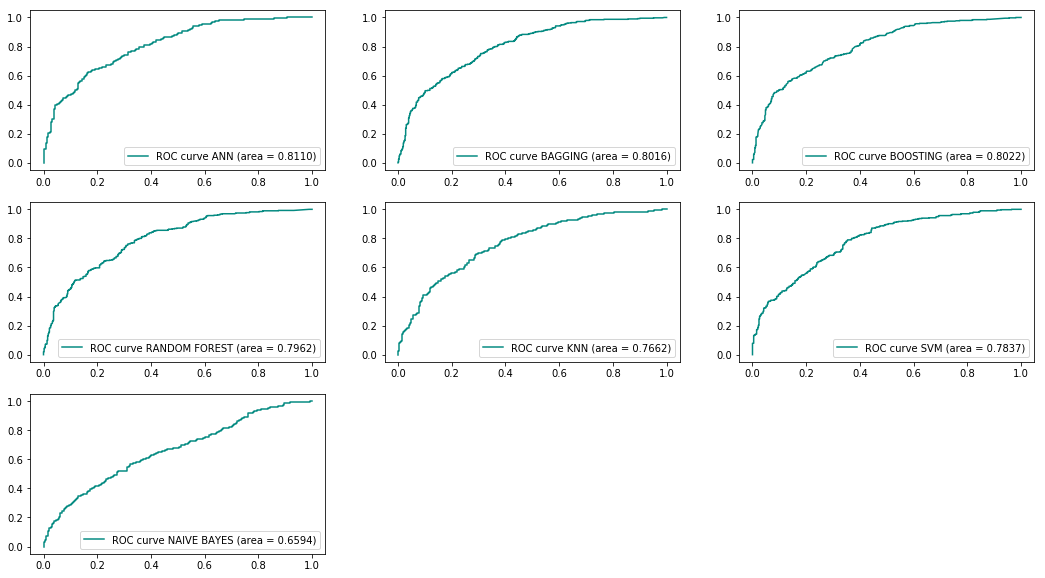

In [84]:
fig = plt.figure(figsize=(18, 10)) 
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
y_score = ann.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr,tpr, label='ROC curve ANN (area = %0.4f)' % roc_auc, color='#048A81')
plt.legend(loc="lower right")

ax = plt.subplot2grid(fig_dims, (0, 1))
y_score = b.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr,tpr, label='ROC curve BAGGING (area = %0.4f)' % roc_auc, color='#048A81')
plt.legend(loc="lower right")

ax = plt.subplot2grid(fig_dims, (0, 2))
y_score = a.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr,tpr, label='ROC curve BOOSTING (area = %0.4f)' % roc_auc, color='#048A81')
plt.legend(loc="lower right")

ax = plt.subplot2grid(fig_dims, (1, 0))
y_score = rf.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr,tpr, label='ROC curve RANDOM FOREST (area = %0.4f)' % roc_auc, color='#048A81')
plt.legend(loc="lower right")

ax = plt.subplot2grid(fig_dims, (1, 1))
y_score = knn.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr,tpr, label='ROC curve KNN (area = %0.4f)' % roc_auc, color='#048A81')
plt.legend(loc="lower right")

ax = plt.subplot2grid(fig_dims, (1, 2))
y_score = s.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr,tpr, label='ROC curve SVM (area = %0.4f)' % roc_auc, color='#048A81')
plt.legend(loc="lower right")

ax = plt.subplot2grid(fig_dims, (2, 0))
y_score = gnb.predict_proba(test_x)
fpr, tpr, _ =  roc_curve(test_y, y_score[:,1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr,tpr, label='ROC curve NAIVE BAYES (area = %0.4f)' % roc_auc, color='#048A81')
plt.legend(loc="lower right")


plt.show()

The AUC scores obtained on the TEST set for the classification methods, in an increasing order, are:
- ANN: 0.8096 (ann)
- Boosting 0.8022 (a)
- Bagging: 0.8015 (b)
- Random Forest: 0.7963 (rf)
- SVM: 0.7837 (s)
- K-NN: 0.7662 (knn)
- Naive Bayes: 0.6594 (gnb)
    
(SVM outmatched K-NN and Boosting outmatched Bagging for AUC)

The ROC curve and the AUC score basically confirms the results obtained with analysis above.

Let's compute all the prediction in order to compute more measurments.

In [85]:
pred_ann = ann.predict(test_x)
pred_b = b.predict(test_x)
pred_a = a.predict(test_x)
pred_rf = rf.predict(test_x)
pred_s = s.predict(test_x)
pred_knn = knn.predict(test_x)
pred_gnb = gnb.predict(test_x)

First of all let's compute another overall performance index: the F-Measure

In [86]:
print "F-Measure_ann", round(f1_score(test_y, pred_ann), 4)
print "F-Measure_b", round(f1_score(test_y, pred_b), 4)
print "F-Measure_a", round(f1_score(test_y, pred_a), 4)
print "F-Measure_rf", round(f1_score(test_y, pred_rf), 4)
print "F-Measure_s", round(f1_score(test_y, pred_s), 4)
print "F-Measure_knn", round(f1_score(test_y, pred_knn), 4)
print "F-Measure_gnb", round(f1_score(test_y, pred_gnb), 4)

F-Measure_ann 0.69
F-Measure_b 0.6807
F-Measure_a 0.673
F-Measure_rf 0.671
F-Measure_s 0.6065
F-Measure_knn 0.6192
F-Measure_gnb 0.5897


Now let's see in particular the two errors. Fist of all let's compute the FP score:

In [87]:
print "FP_ann", confusion_matrix(test_y, pred_ann)[0][1]
print "FP_b", confusion_matrix(test_y, pred_b)[0][1]
print "FP_a", confusion_matrix(test_y, pred_a)[0][1]
print "FP_rf", confusion_matrix(test_y, pred_rf)[0][1]
print "FP_s", confusion_matrix(test_y, pred_s)[0][1]
print "FP_knn", confusion_matrix(test_y, pred_knn)[0][1]
print "FP_gnb", confusion_matrix(test_y, pred_gnb)[0][1]

FP_ann 91
FP_b 107
FP_a 96
FP_rf 112
FP_s 76
FP_knn 80
FP_gnb 167


And then the FN:

In [88]:
print "FN_ann", confusion_matrix(test_y, pred_ann)[1][0]
print "FN_b", confusion_matrix(test_y, pred_b)[1][0]
print "FN_a", confusion_matrix(test_y, pred_a)[1][0]
print "FN_rf", confusion_matrix(test_y, pred_rf)[1][0]
print "FN_s", confusion_matrix(test_y, pred_s)[1][0]
print "FN_knn", confusion_matrix(test_y, pred_knn)[1][0]
print "FN_gnb", confusion_matrix(test_y, pred_gnb)[1][0]

FN_ann 139
FN_b 136
FN_a 146
FN_rf 139
FN_s 190
FN_knn 182
FN_gnb 160


Let's take, for each method, the records that are ill classified.

In [89]:
wrong_ann = df.loc[test_y != pred_ann]
wrong_b = df.loc[test_y != pred_b]
wrong_a = df.loc[test_y != pred_a]
wrong_rf = df.loc[test_y != pred_rf]
wrong_s = df.loc[test_y != pred_s]
wrong_knn = df.loc[test_y != pred_knn]
wrong_gnb = df.loc[test_y != pred_gnb]

For example we can plot the distribution of the wrong classified records for ANN and Bagging, to understand how much they overlap and if there are big differences.

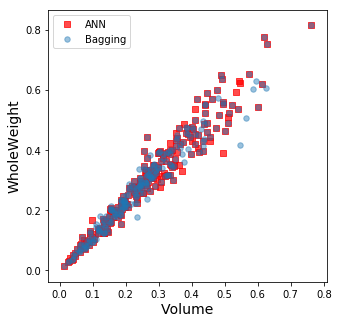

In [90]:
fig = plt.figure(figsize=(5, 5)) 
fig_dims = (1, 1)

ax = plt.subplot2grid(fig_dims, (0, 0))
plt.scatter(wrong_ann["Volume"], wrong_ann["WholeWeight"], alpha=0.7, color="red", s=30, marker="s")
plt.scatter(wrong_b["Volume"], wrong_b["WholeWeight"], alpha=0.45, s=30, marker="o")
plt.xlabel('Volume', fontsize=14)
plt.ylabel('WholeWeight', fontsize=14)
plt.legend(('ANN', 'Bagging'))

plt.savefig('Images/Classification/AnnVsBag.png', format='png', bbox_inches='tight')
plt.show()

The distribution of the error for these two methods is similar. The results does not change much if we take two different methods or we do the scatter plot with different variables.

Let's plot for ANN the distribution of the error in the two classes for the variables Volume and WholeWeight.

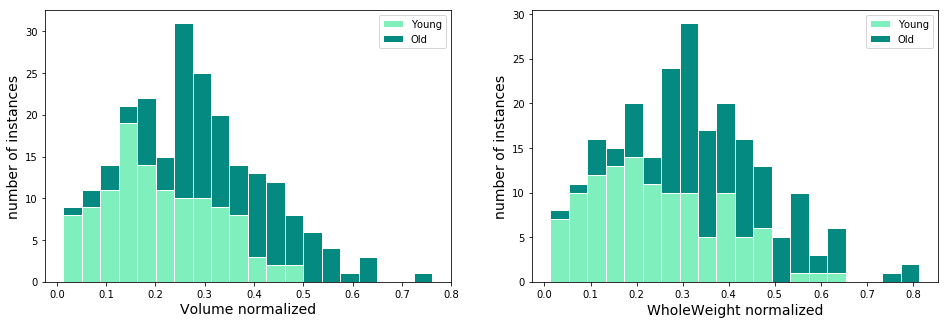

In [91]:
fig = plt.figure(figsize=(16, 5)) 
fig_dims = (1, 2)

ax = plt.subplot2grid(fig_dims, (0, 0))
n_bins = 20
x =[wrong_ann[wrong_ann["Class"] == 0]["Volume"], wrong_ann[wrong_ann["Class"] == 1]["Volume"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
plt.xlabel('Volume normalized', fontsize=14)
plt.ylabel('number of instances', fontsize=14)
plt.legend(('Young', 'Old'))

ax = plt.subplot2grid(fig_dims, (0, 1))
x =[wrong_ann[wrong_ann["Class"] == 0]["WholeWeight"], wrong_ann[wrong_ann["Class"] == 1]["WholeWeight"]]
ax.hist(x, n_bins, histtype='bar', stacked=True, color=['#7FEFBD', '#048A81'],  ec='#FFFFFF')
plt.xlabel('WholeWeight normalized', fontsize=14)
plt.ylabel('number of instances', fontsize=14)
plt.legend(('Young', 'Old'))

plt.savefig('Images/Classification/ErrorDistribution.png', format='png', bbox_inches='tight')
plt.show()

The distribution of the records still resemble a gassian, but it's shorter, which means that the variance is higher, so that the error in the tail is higher than in the middle.